## Load libraries 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Data Exploration

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.shape

(284807, 31)

In [5]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

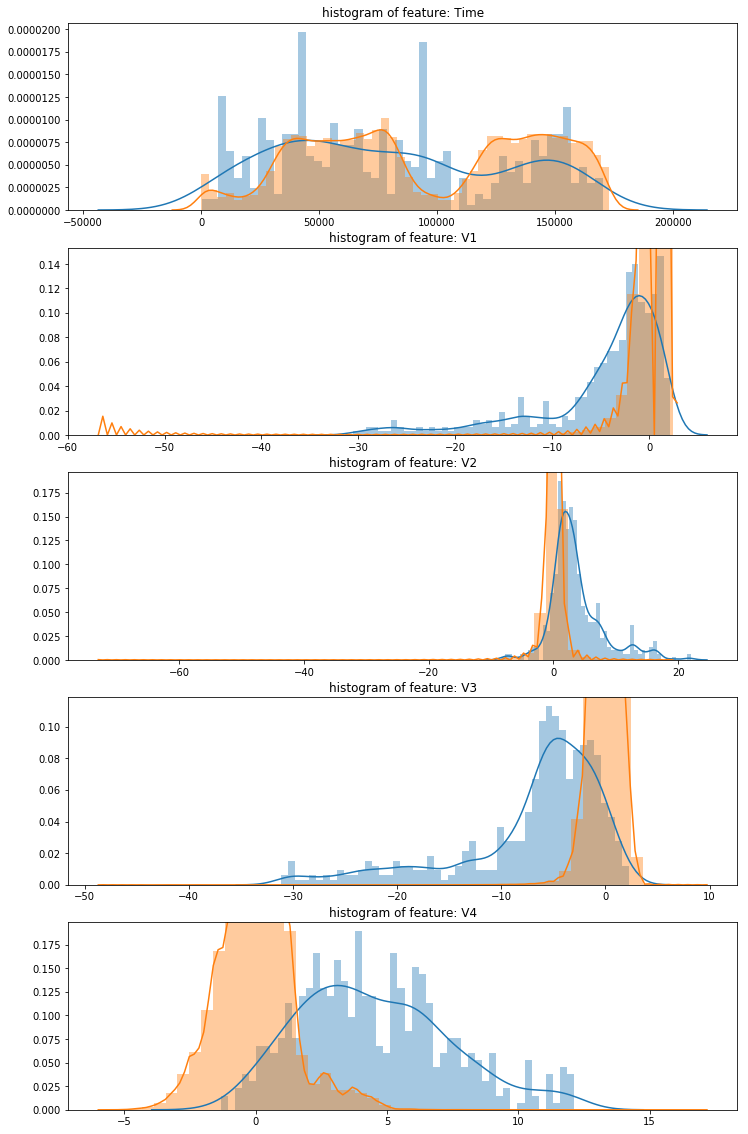

In [9]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

## Train and test split on time series, using first 70% as training/val, and last 30% as test

In [10]:
TEST_RATIO = 0.3
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [11]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 199364, total fraud cases: 384, equal to 0.00193 of total cases. 


In [12]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 85443, total fraud cases: 108, equal to 0.00126 of total cases. 


## Feature Normalization - min max score (used for sigmoid activation)

In [13]:
'''cols_max = []
cols_min = []
for c in range(train_x.shape[1]):
    cols_max.append(train_x[:,c].max())
    cols_min.append(train_x[:,c].min())
    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])
    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'''

'cols_max = []\ncols_min = []\nfor c in range(train_x.shape[1]):\n    cols_max.append(train_x[:,c].max())\n    cols_min.append(train_x[:,c].min())\n    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])\n    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'

## Feature Normalization 2 - z score (for tanh activation)

In [14]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## Modelling and results


## 1. Auto-encoder as unsupervised learning

### Parameters

In [15]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

### Train and val the model - (1 hidden layer turned out to be enough)

In [16]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Epoch: 0001 cost= 0.913390934 Train auc= 0.953296 Time elapsed= 0:00:02.272661
Epoch: 0002 cost= 0.741026878 Train auc= 0.956147 Time elapsed= 0:00:03.342446
Epoch: 0003 cost= 0.456544250 Train auc= 0.955538 Time elapsed= 0:00:04.370958
Epoch: 0004 cost= 0.577538073 Train auc= 0.956654 Time elapsed= 0:00:05.463154
Epoch: 0005 cost= 0.413881570 Train auc= 0.957325 Time elapsed= 0:00:06.546711
Epoch: 0006 cost= 0.504470706 Train auc= 0.956900 Time elapsed= 0:00:07.555885
Epoch: 0007 cost= 0.773460567 Train auc= 0.956599 Time elapsed= 0:00:08.535635
Epoch: 0008 cost= 0.354237825 Train auc= 0.956186 Time elapsed= 0:00:09.565419
Epoch: 0009 cost= 0.533969939 Train auc= 0.953960 Time elapsed= 0:00:10.848785
Epoch: 0010 cost= 0.278826296 Train auc= 0.953206 Time elapsed= 0:00:12.168479
Optimization Finished!
Model saved in file: ./temp_saved_model_1layer.ckpt


### Test model - on later 25% test data

In [17]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))
    

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Test auc score: 0.942872


In [18]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
    
    print("train auc score: {:.6f}".format(auc(train_y, train_batch_mse)))
    

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
train auc score: 0.953206


In [19]:
from sklearn.metrics import f1_score


In [20]:
from sklearn.metrics import classification_report

In [21]:
test_batch_mse

array([ 0.08665185,  0.13225064,  0.32095471, ...,  0.52959889,
        0.29146653,  0.09622633], dtype=float32)

## Visualize the prediction

### 1. Display fraud score (mse) distribution for non-fraud cases

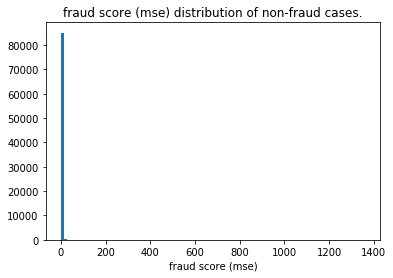

In [22]:
plt.hist(test_batch_mse[test_y == 0.0], bins = 100)
plt.title("fraud score (mse) distribution of non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

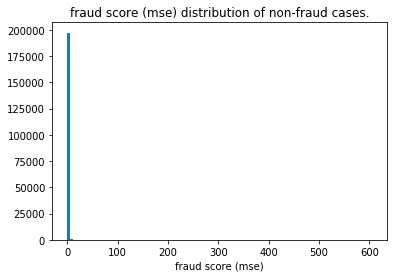

In [23]:
plt.hist(train_batch_mse[train_y == 0.0], bins = 100)
plt.title("fraud score (mse) distribution of non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

### Zoom into (0, 20) range

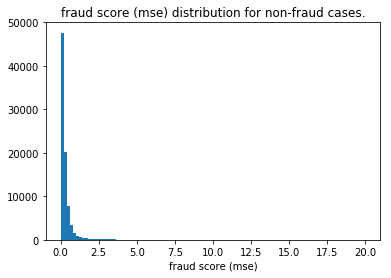

In [24]:
plt.hist(test_batch_mse[(test_y == 0.0) & (test_batch_mse < 20)], bins = 100)
plt.title("fraud score (mse) distribution for non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

### 2. Display fraud score (mse) distribution for fraud cases

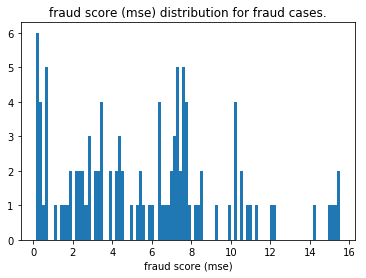

In [25]:
plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
plt.title("fraud score (mse) distribution for fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

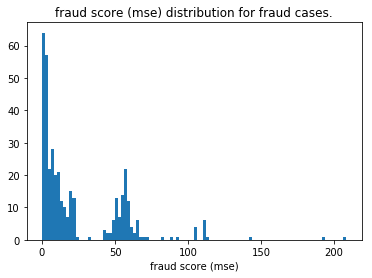

In [26]:
plt.hist(train_batch_mse[train_y == 1.0], bins = 100)
plt.title("fraud score (mse) distribution for fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

In [27]:
THRE_TEST = 7
print("Let's, for example, use 7 as our detection threshold: \n\
Number of detected cases above treshold: {}, \n\
Number of pos cases only above threshold: {}, \n\
The percentage of accuracy above treshold (Precision): {:0.2f}%. \n\
Compared to the average percentage of fraud in test set: 0.132%".format( \
np.sum(test_batch_mse > THRE_TEST), \
np.sum(test_y[test_batch_mse > THRE_TEST]), \
np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST) * 100))
      

Let's, for example, use 7 as our detection threshold: 
Number of detected cases above treshold: 665, 
Number of pos cases only above threshold: 44, 
The percentage of accuracy above treshold (Precision): 6.62%. 
Compared to the average percentage of fraud in test set: 0.132%


test_batch_mse[test_batch_mse>THRE_TEST]=1
test_batch_mse[test_batch_mse<THRE_TEST]=0

In [28]:
d =[]
for i in test_batch_mse:
    if i>THRE_TEST:
        d.append(1)
    else:
        d.append(0)
#test_batch_mse[test_batch_mse>THRE_TEST]=1
#test_batch_mse[test_batch_mse<THRE_TEST]=0


In [29]:
d_train =[]
for i in train_batch_mse:
    if i>THRE_TEST:
        d_train.append(1)
    else:
        d_train.append(0)

In [30]:
print(test_batch_mse)

[ 0.08665185  0.13225064  0.32095471 ...,  0.52959889  0.29146653
  0.09622633]


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y,d)

array([[84714,   621],
       [   64,    44]])

In [32]:

confusion_matrix(train_y,d_train)

array([[197534,   1446],
       [   153,    231]])

In [33]:
print(classification_report(train_y,d_train))
print(classification_report(test_y,d))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00    198980
          1       0.14      0.60      0.22       384

avg / total       1.00      0.99      0.99    199364

             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85335
          1       0.07      0.41      0.11       108

avg / total       1.00      0.99      0.99     85443

